In [1]:
from Solvers import adv_solver, span_solver, span_solver2, span_dual_relax, ket
from Adversary import Adversary, Problem, to_str, visualize
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
from Span import SpanProgram
mpl.rcParams['figure.dpi'] =200

In [2]:
def witness_cost(W):
    return np.max(np.linalg.norm(W, axis=0))**2

def span_vectors_mask(prob, d):
    mask = np.zeros((prob.no_len, prob.n, len(prob.alphabet), d))
    for no_index in range(prob.no_len):
        no = prob.no_instances[no_index]
        for j in range(prob.n):
                for b_index in range(len(prob.alphabet)):
                    if no[j] != prob.alphabet[b_index]:
                        for i in range(d):
                            mask[no_index, j, b_index, i] = 1
    return mask.reshape((prob.no_len, -1))

def monotone_mask(prob, d):
    mask = np.zeros((prob.no_len, prob.n, len(prob.alphabet), d))
    for no_index in range(prob.no_len):
        for j in range(prob.n):
            for i in range(d):
                mask[no_index,j,0,i] = 1
    return mask.reshape((prob.no_len, -1))
    
def span_vectors_solver(prob, witnesses, d, solver_params=None, monotone=False):
    n = prob.n
    size = d * n * len(prob.alphabet)
    t = cp.Variable(nonneg=True)
    A = cp.Variable((prob.no_len, size))
    constraints = [t >= witness_cost(W)]
    for no_index in range(prob.no_len):
        constraints.append(cp.norm(A[no_index,:]**2)<= t)
    
    constraints+= [
        A @ W == np.ones((prob.no_len, prob.yes_len))
    ]
    
    constraints += [A == cp.multiply(span_vectors_mask(prob, d), A)]
    if monotone:
        print(monotone_mask(prob, d))
        constraints += [cp.multiply(A, monotone_mask(prob, d))==0]
    problem = cp.Problem(cp.Minimize(t), constraints)
    problem.solve(solver="SCS",verbose=True)
    return A.value
    
    

def default_witness(problem, d, random=False):
    n = problem.n
    alpha_len = len(problem.alphabet)
    size = n * alpha_len * d
    W = np.zeros((n, alpha_len, d, problem.yes_len))
    for yes_index in range(problem.yes_len):
        yes = problem.yes_instances[yes_index]
        for j in range(n):
            b = yes[j]
            for i in range(d):
                W[ j, problem.alphabet.index(b), i, yes_index] = 1
                if random:
                    W[j, problem.alphabet.index(b), i, yes_index] = np.random.rand(1)

    return W.reshape((-1, problem.yes_len))

######################## dual

def dual_witness_selection(problem, d, no, j, i):
    alpha_len = len(problem.alphabet)
    n = problem.n
    size = d * n * len(problem.alphabet)
    v = np.zeros((n, len(problem.alphabet), d))
    v[j, no[j], i] = 1
    v = v.reshape((-1,))
#     print(v.shape, ket(problem.no_instances.index(no), problem.no_len).shape)
    return np.outer(v, ket(problem.no_instances.index(no), problem.no_len))
    
def dual_pair_mask(problem, j):
    mask = np.zeros((problem.yes_len, problem.no_len))
    for yes_index in range(problem.yes_len):
        yes = problem.yes_instances[yes_index]
        for no_index in range(problem.no_len):
            no = problem.no_instances[no_index]
            if yes[j] != no[j]:
                mask[yes_index, no_index] = 1
    return mask

def dual_span_vectors_solver(problem, W, d):
    n = problem.n
    alpha_len = len(problem.alphabet)
    size = d * n * alpha_len
    Wr = W.reshape((n, alpha_len, d, problem.yes_len))
    G = cp.Variable((problem.yes_len, problem.no_len))
    constraints = []
    for no_index in range(problem.no_len):
        no = problem.no_instances[no_index]
        for j in range(n):
            for i in range(d):
                sum_list = []
                for yes_index in range(problem.yes_len):
                    yes = problem.yes_instances[yes_index]
                    if yes[j] != no[j]:
                        print(Wr[j, yes[j], i, yes_index])
                        sum_list.append(G[yes_index, no_index] * Wr[j, yes[j], i, yes_index])
                constraints += [
                    cp.sum(cp.vstack(sum_list)) == 0
                ]
    
    opt_prob = cp.Problem(cp.Maximize( cp.sum(G)), constraints)
    opt_prob.solve( verbose=True)
    return G.value

    # need length and hamming weight to be the same
def perm_travel(x, y):
    perm = list(range(len(x)))
    one_indices_y = []
    one_indices_x = []
    for i in range(len(x)):
        if x[i] != y[i]:
            if y[i] == 1:
                one_indices_y.append(i)
            else:
                one_indices_x.append(i)
    for i in range(len(one_indices_x)):
        x_ind = one_indices_x[i]
        y_ind = one_indices_y[i]
        perm[x_ind] = y_ind
        perm[y_ind] = x_ind
    return perm

def perm_witnesses(prob, d, random=False):
    W = np.zeros((prob.n, len(prob.alphabet), d, prob.yes_len))
    first_yes = prob.yes_instances[0]
    W_temp = default_witness(prob, d, random)
    W[:,:,:,0] = W_temp.reshape((prob.n, len(prob.alphabet), d, prob.yes_len))[:,:,:,0]
    for yes_index in range(1, prob.yes_len):
        perm = perm_travel(first_yes, prob.yes_instances[yes_index])
        W[:,:,:, yes_index] = W[perm,:,:, 0]
    return W.reshape((-1, prob.yes_len))

In [34]:
n = 7
k=3
prob = threshold_k(n,k)
d = 1
size = n * len(prob.alphabet) * d
W = perm_witnesses(prob, d, random=0)
print(W)
W = W
A = span_vectors_solver(prob, W, d)
# G = dual_span_vectors_solver(prob, W, d)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
  0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 0. 1.

rank 7 (14, 35)
[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1), (6, 0), (6, 1)]
['0000011', '0000101', '0000110', '0001001', '0001010', '0001100', '0010001', '0010010', '0010100', '0011000', '0100001', '0100010', '0100100', '0101000', '0110000', '1000001', '1000010', '1000100', '1001000', '1010000', '1100000']
(21, 14)


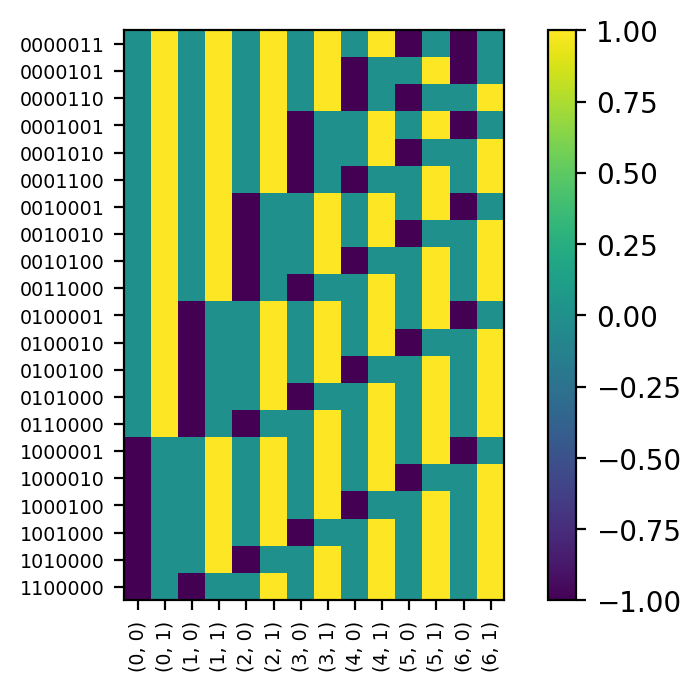

[[ 0.  1.  0.  1.  0.  1.  0.  1.  0.  1. -1.  0. -1.  0.]
 [ 0.  1.  0.  1.  0.  1.  0.  1. -1.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  1.  0.  1.  0.  1. -1.  0. -1.  0.  0.  1.]
 [ 0.  1.  0.  1.  0.  1. -1.  0.  0.  1.  0.  1. -1.  0.]
 [ 0.  1.  0.  1.  0.  1. -1.  0.  0.  1. -1.  0.  0.  1.]
 [ 0.  1.  0.  1.  0.  1. -1.  0. -1.  0.  0.  1.  0.  1.]
 [ 0.  1.  0.  1. -1.  0.  0.  1.  0.  1.  0.  1. -1.  0.]
 [ 0.  1.  0.  1. -1.  0.  0.  1.  0.  1. -1.  0.  0.  1.]
 [ 0.  1.  0.  1. -1.  0.  0.  1. -1.  0.  0.  1.  0.  1.]
 [ 0.  1.  0.  1. -1.  0. -1.  0.  0.  1.  0.  1.  0.  1.]
 [ 0.  1. -1.  0.  0.  1.  0.  1.  0.  1.  0.  1. -1.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  1.  0.  1. -1.  0.  0.  1.]
 [ 0.  1. -1.  0.  0.  1.  0.  1. -1.  0.  0.  1.  0.  1.]
 [ 0.  1. -1.  0.  0.  1. -1.  0.  0.  1.  0.  1.  0.  1.]
 [ 0.  1. -1.  0. -1.  0.  0.  1.  0.  1.  0.  1.  0.  1.]
 [-1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1. -1.  0.]
 [-1.  0.  0.  1.  0.  1.  0.  1.  0.  1. -1.  0.  0.  1

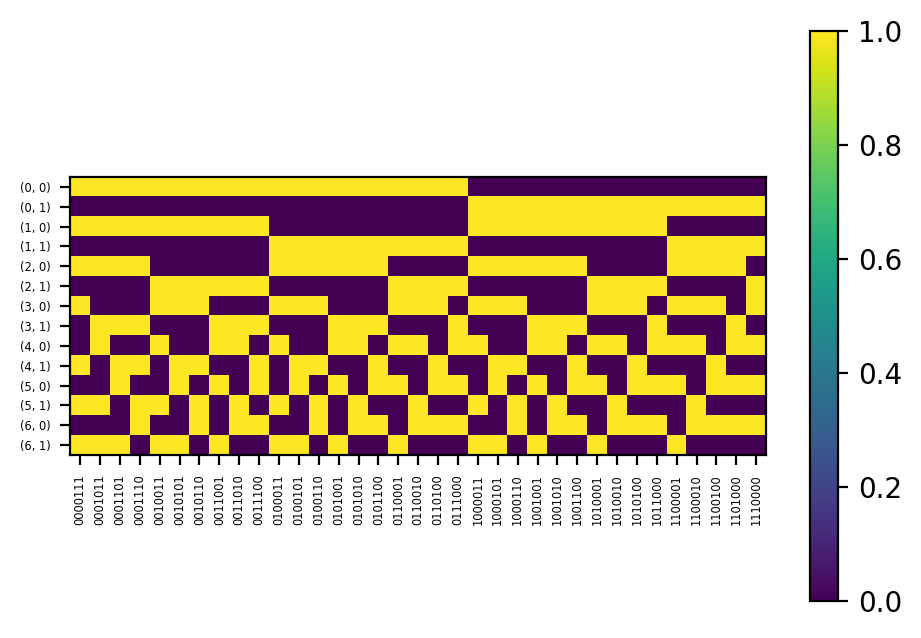

In [35]:
# A = span_vectors_solver(prob,W, d)
Ar = A.reshape((prob.no_len, n, len(prob.alphabet), d))
I_dict = {}
for j in range(n):
    for b_index in range(len(prob.alphabet)):
        b = prob.alphabet[b_index]
        I_dict[(j,b)] = []
        for i in range(d):
            I_dict[(j,b)].append(Ar[:,j,b,i])
print("rank", np.linalg.matrix_rank(W), W.shape)
Ar = A.reshape((prob.no_len, n, len(prob.alphabet), d))
Ar = np.round(Ar, 7)


I_dict = {}
for j in range(n):
    for b_index in range(len(prob.alphabet)):
        b = prob.alphabet[b_index]
        I_dict[(j,b)] = []
        for i in range(d):
            I_dict[(j,b)].append(Ar[:,j,b,i])
sp = SpanProgram(prob, I_dict, witnesses=W.T)
sp.visualize_A()
print(sp.A)
print(np.linalg.norm(sp.A, axis=1)**2)
sp.visualize_witnesses()

{1.0, 3.0, 5.0, 7.0}
{-0.0012, -0.0062, 0.0088, 0.0038}
7


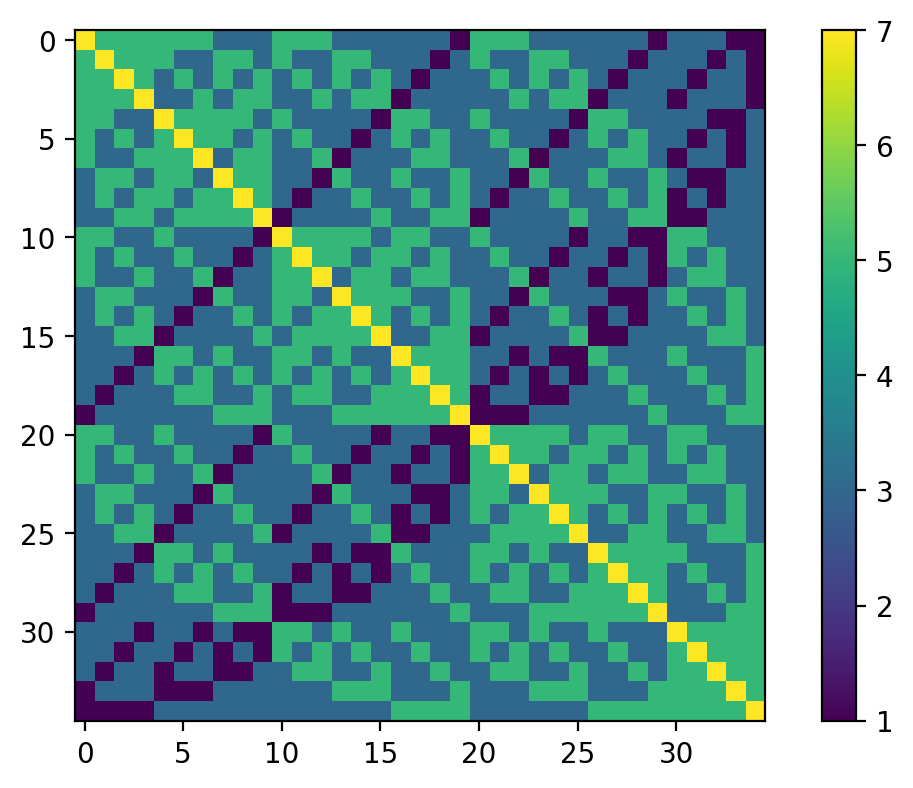

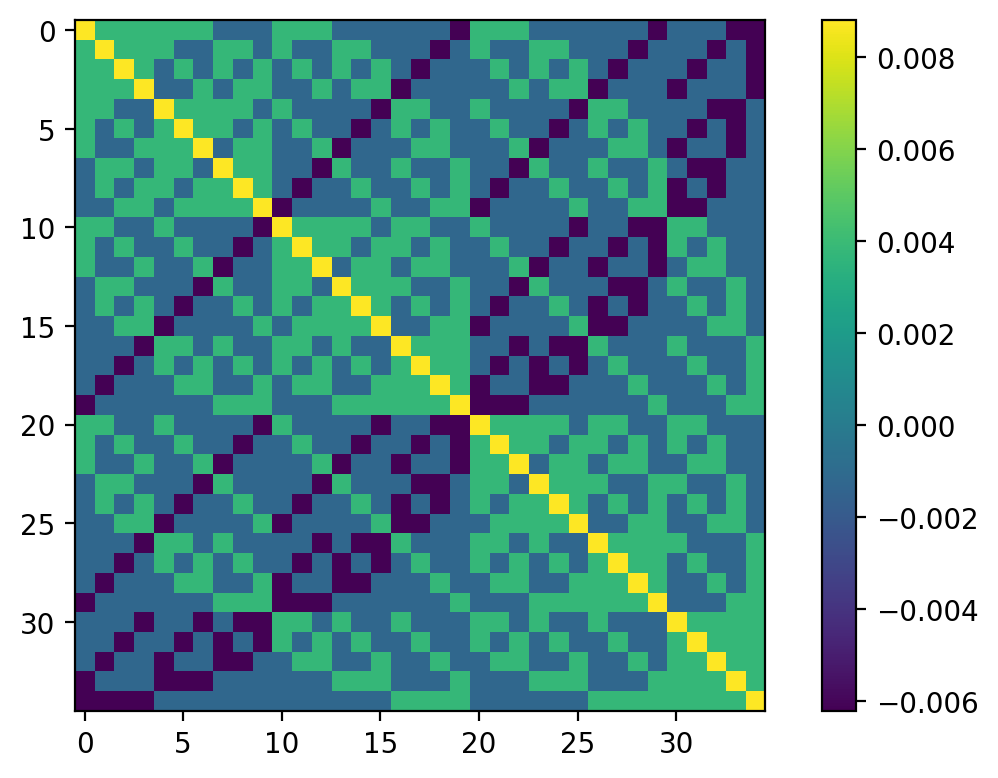

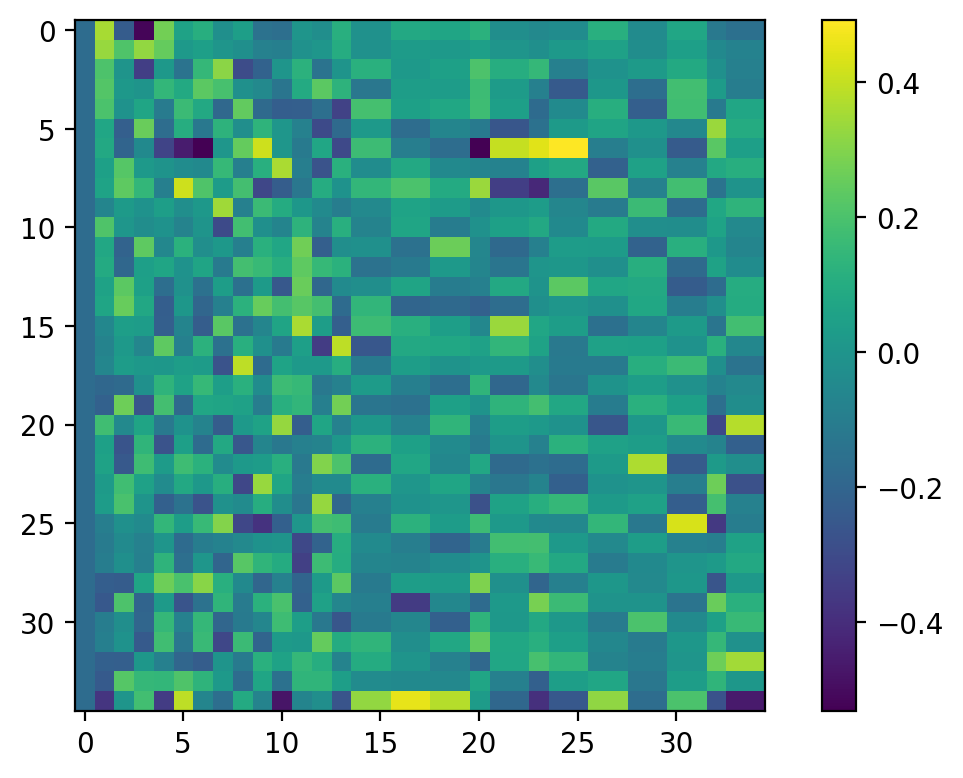

In [43]:
witness_gram = W.T@W
witness_inv = np.linalg.pinv(W.T@W)
gram_vals = set(list(witness_gram.flatten()))
inv_vals = set(list(np.round(witness_inv.flatten(), 8)))
print(gram_vals)
print(inv_vals)
print(np.linalg.matrix_rank(witness_gram))
visualize(witness_gram)
visualize(witness_inv)
visualize(np.real(np.linalg.eig(witness_gram)[1]))

In [9]:
def get_naive_Gamma(prob):
    return np.ones((prob.no_len, prob.yes_len))
def get_naive_Phi(prob, d):
    Phi = np.zeros((prob.no_len, prob.n,  len(prob.alphabet), d))
    for no_index in range(prob.no_len):
        no = prob.no_instances[no_index]
        for j in range(prob.n):
            for i in range(d):
                print(no_index, j, i, no[j])
                Phi[no_index, j,no[j], i] = 1
    print('here')
    print(Phi[(1,0,0),0,0,0])
    return Phi.reshape((prob.no_len, -1))



In [400]:
Gamma = get_naive_Gamma(prob)
Phi = get_naive_Phi(prob, d)

0 0 0 0
0 1 0 0
0 2 0 1
1 0 0 0
1 1 0 1
1 2 0 0
2 0 0 1
2 1 0 0
2 2 0 0
here
[1. 1. 1.]


In [410]:
new_gamma = Gamma * np.random.random(Gamma.shape)
print(new_gamma)
print(W)
print(Phi)
print(new_gamma@W.T)
print((new_gamma@W.T)*(np.ones(Phi.shape)-Phi)@ W)

[[0.47528642 0.7945715  0.59792285]
 [0.74621372 0.55105516 0.05165854]
 [0.98620174 0.62275357 0.0530595 ]]
[[0.12644873 0.         0.        ]
 [0.         0.31801095 0.11022823]
 [0.         0.12644873 0.        ]
 [0.31801095 0.         0.31801095]
 [0.         0.         0.12644873]
 [0.11022823 0.11022823 0.        ]]
[[1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 1. 0.]]
[[0.06009937 0.31859042 0.10047256 0.3412923  0.07560659 0.13997419]
 [0.09435778 0.18093581 0.06968023 0.25373212 0.00653216 0.14299566]
 [0.12470396 0.20389111 0.0787464  0.33049646 0.00670931 0.1773523 ]]
[[0.10853469 0.10131524 0.15321271]
 [0.01576216 0.0821127  0.01994423]
 [0.14041938 0.01954923 0.10510149]]
